# Database creation
This file is used to play with the data and once the objective is reached, functions will be written in .py files in order to be used by the model part of the project.

In [1]:
from astropy.io import fits
from tabulate import tabulate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dataset_creation_utils import *
# Retrieve the contrast curves from the database
path_db = 'C:/Users/ludin/Documents/Master Thesis/Dataset_creation/SPHERE_DC_DATA/'
foldername = '2MASS J01543773+0043005_DB_H23_2014-10-07_ird_specal_dc_cADI_softsorting_200967/'
filename = 'ird_specal_dc-IRD_SPECAL_CONTRAST_CURVE_TABLE-contrast_curve_tab.fits'

if not os.path.exists(path_db):
    print('ERROR! Folder {} does not exist.'.format(path_db)) # exit doesn't print anything in jupyter notebook

if not os.path.exists(os.path.join(path_db, foldername)):
    print('ERROR! Folder {} does not exist.'.format(foldername))

if not os.path.exists(os.path.join(path_db, foldername, filename)):
    print('ERROR! File {} does not exist.'.format(filename))

# Example of how to read a fits file
with fits.open(os.path.join(path_db, foldername, filename)) as hdul:
    data = hdul[1].data #numpy record
    print(data.dtype)
    # print(hdul[1].header['DATE-OBS'])
    # print(hdul[1].data['TARGET_NAME'])

(numpy.record, [('TARGET_NAME', 'S3'), ('LAM', 'S10'), ('PIXSCALE', 'S10'), ('NSIGMA', 'S3'), ('REPERTORY', 'S55'), ('SEPARATION', '>f4', (1148,)), ('NSIGMA_CONTRAST', '>f4', (1148,))])


Get a dataframe with the specified headers. Plots, summary statistics, ... can be computed if desired (not to be re-done each time).

In [2]:
df = get_df_with_headers(path_db, ['ESO OBS ID', 'DATE-OBS', 'OBJECT'], interpolate=True, compute_summary=False, write_headers=False, compute_plots=False, max_sep=10)
# df

In [3]:
# Print the types of the columns
print(df.dtypes)

folder             object
ESO OBS ID          int64
DATE-OBS           object
OBJECT             object
SEPARATION         object
NSIGMA_CONTRAST    object
dtype: object


This plot is a summary plot of all the contrast curves, no anomaly detection has been performed.

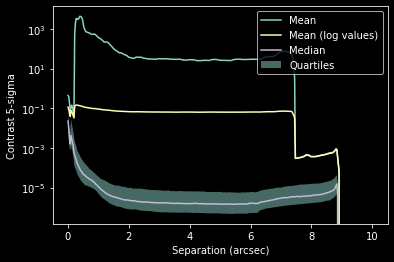

In [4]:
plot_contrast_curves_summary(path_db, df, filename='contrast_curves_summary_raw.png')

Now the sum of the absolute differences between the contrast curves and the median contrast curve (using log values) is used as deviation measure.

In [5]:
df['ABS DEV'] = get_abs_deviations_from_median(df)
df

,folder,ESO OBS ID,DATE-OBS,OBJECT,SEPARATION,NSIGMA_CONTRAST,ABS DEV
0,++ CVN 3B_DB_H23_2018-09-14_ird_specal_dc_cADI...,2177825,2018-09-15T07:33:22.60,CD-52 381,"[0.006105000153183937, 0.030420974449882253, 0...","[0.07546933740377426, 0.07712596848056678, 0.0...",0.059784
1,++ KOH 78_DB_H23_2016-04-03_ird_specal_dc_cADI...,1182440,2016-04-04T07:59:57.8491,ScoPMS_048,"[0.006105000153183937, 0.030420974449882253, 0...","[0.024168867617845535, 0.013727830975673552, 0...",0.005935
2,++ SKF 1501_DB_H23_2015-04-11_ird_specal_dc_cA...,1182371,2015-04-12T07:15:49.8435,HIP_76629,"[0.006105000153183937, 0.030420974449882253, 0...","[0.01883835159242153, 0.008466474323989774, 0....",0.006940
3,1RXS J184646.0-363621_DB_H23_2018-07-04_ird_sp...,1962017,2018-07-05T01:24:56.95,RXJ1846,"[0.006105000153183937, 0.030420974449882253, 0...","[0.13829022645950317, 0.12528548200099757, 0.0...",5.434390
4,1RXS J184646.0-363621_DB_H23_2018-07-04_ird_sp...,1962017,2018-07-05T01:24:56.95,RXJ1846,"[0.006105000153183937, 0.030420974449882253, 0...","[0.13829022645950317, 0.12528548200099757, 0.0...",5.434390
...,...,...,...,...,...,...,...
509,TYC 7692-2943-2_DB_H23_2019-03-19_ird_specal_d...,2296758,2019-03-20T02:23:21.23,TYC 7692-2943-2,"[0.006105000153183937, 0.030420974449882253, 0...","[0.021788790822029114, 0.01076361939993451, 0....",0.005664
510,TYC 7692-2943-2_DB_H23_2019-03-24_ird_specal_d...,2296758,2019-03-25T02:18:36.93,TYC 7692-2943-2,"[0.006105000153183937, 0.030420974449882253, 0...","[0.011126062832772732, 0.0070464837691727195, ...",0.011772
511,TYC 8092-1574-2_DB_H23_2016-10-01_ird_specal_d...,1424674,2016-10-02T08:50:23.1564,HIP 28153,"[0.006105000153183937, 0.030420974449882253, 0...","[0.030811656266450882, 0.007723410447323252, 0...",0.022321
512,TYC 8097-337-1_DB_H23_2018-10-31_ird_specal_dc...,2028801,2018-11-01T07:33:29.10,TYC 8097-337-1,"[0.006105000153183937, 0.030420974449882253, 0...","[0.011241959407925606, 0.0068635571590479495, ...",0.011493


The distribution of these deviations is showed and some outliers can be observed.

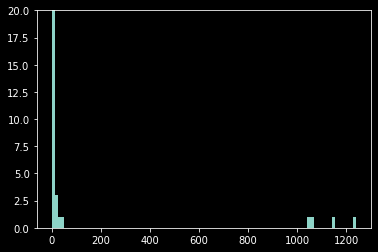

In [6]:
# Plot the distribution of the absolute deviations from the median
plt.hist(df['ABS DEV'], bins=100)	
# plt.xlim(0, 100)
plt.ylim(0, 20)
plt.show()

The cut-off criterion has been chosen (arbitrarly) and a new summary plot has been computed in order to be compared to the previous one.

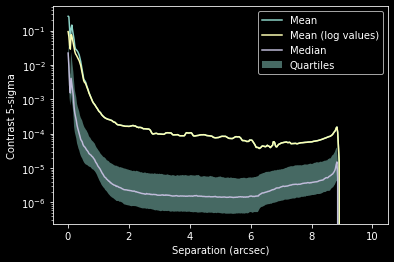

In [8]:
df_AD = remove_contrast_anomalies(path_db, df, threshold=10)

# Plot the new summary of the contrast curves
plot_contrast_curves_summary(path_db, df_AD, filename='contrast_curves_summary_anomaly_detection.png')